## Introducción

Los conjuntos de datos a menudo pueden contener valores atípicos: puntos que son diferentes o están lejos de la mayoría de los datos. Hay varias razones por las que estos puntos de datos pueden aparecer en conjuntos de datos. Pueden representar observaciones inusuales o errores en la entrada de datos. De cualquier manera, pueden afectar en gran medida la precisión de un modelo de aprendizaje automático o del análisis estadístico en general. Como tal, durante el preprocesamiento de datos, uno de los objetivos es detectar valores atípicos en el conjunto de datos; sin embargo, a pesar de los posibles efectos negativos en análisis futuros, eliminar todos los valores atípicos identificados es una elección equivocada. Los valores atípicos pueden servir como indicadores útiles de posibles tendencias que el analista puede haber pasado por alto o señalar excepciones que pueden ser muy importantes para el modelo del científico. Deberíamos intentar eliminar sólo los valores atípicos, que son claramente errores de entrada de datos o extremadamente poco realistas, ya que no ayudan en absoluto al análisis.

La detección de valores atípicos puede resultar desafiante, porque cada conjunto de datos tiene datos diferentes y distribuciones de datos diferentes; por tanto, es esencial conocer una variedad de técnicas de detección de valores atípicos. En este cuaderno, nos centraremos en el algoritmo de agrupación espacial de aplicaciones con ruido basada en densidad (DBSCAN). Tenga en cuenta que todos estos métodos son técnicas no paramétricas de detección de valores atípicos, ya que no siempre podemos hacer suposiciones sobre la distribución de los datos.

Este conjunto de datos es perfecto para este notebook, ya que contiene errores de ingreso de datos y, al mismo tiempo, contiene observaciones que probablemente sean precisas, pero que son inusuales para el conjunto de datos.

Para comprender qué tan efectivo es cada uno de los métodos, analizaremos más de cerca las observaciones que se identificaron como valores atípicos y obtendremos información a partir de esas observaciones. Además, también optimizaremos algunas de las técnicas para obtener una comprensión más profunda de cómo utilizar los métodos y qué tan efectivos son para detectar valores atípicos. Finalmente, después de aplicar una técnica al conjunto de datos, también sopesaremos sus pros y sus contras y llegaremos a una conclusión sobre el método de detección de valores atípicos.


In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy.stats import chi2
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
#from torchmetrics.functional import r2_score
from sklearn import svm
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
from torch import Tensor
from torch.optim import Adam
import seaborn as sns
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
from plotly.offline import  init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import plotly.express as px  
import warnings
warnings.filterwarnings("ignore")

In [2]:
!pip install torchmetrics

Cargamos el conjunto de datos y asignando su longitud a una variable

In [5]:
houses = pd.read_csv("houses_to_rent_v2.csv")
original_length = len(houses)
houses.head()

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$)
0,São Paulo,70,2,1,1,7,acept,furnished,2065,3300,211,42,5618
1,São Paulo,320,4,4,0,20,acept,not furnished,1200,4960,1750,63,7973
2,Porto Alegre,80,1,1,1,6,acept,not furnished,1000,2800,0,41,3841
3,Porto Alegre,51,2,1,0,2,acept,not furnished,270,1112,22,17,1421
4,São Paulo,25,1,1,0,1,not acept,not furnished,0,800,25,11,836


La columna floor tiene algunos valores no numéricos ('-'), estos serán reemplazados por 0, ya que estoy asumiendo que '-' indica una casa de un solo piso y no indica datos faltantes.

In [6]:
houses.replace({"-": 0}, inplace=True)
houses["floor"] = houses["floor"].astype(int)
# Aparte de esto, no hay otros datos potencialmente faltantes en el conjunto de datos.

# seleccionamos columnas numéricas
houses = houses.select_dtypes(include=np.number)

## DBSCAN (agrupación espacial de aplicaciones con ruido basada en densidad)

DBSCAN es un algoritmo de agrupación, lo que significa que clasifica datos determinados en categorías determinadas automáticamente, en función de la distancia euclidiana entre puntos de datos. Una de las categorías que el algoritmo puede identificar son los valores atípicos. DBSCAN está disponible en el paquete de aprendizaje sci-kit.

El algoritmo tiene dos parámetros: eps y min_samples. Eps, que significa épsilon, es la distancia máxima que puede estar un punto de datos de otro punto de datos para ser considerado parte de la misma clase. Min_samples, que significa muestras mínimas, es el número mínimo de puntos de datos en el radio épsilon de otro punto de datos necesarios para que se considere un punto central; esto incluye el punto en sí.

Usaremos este algoritmo de agrupamiento para identificar valores atípicos en nuestro conjunto de datos. Al principio usaremos los parámetros predeterminados; sin embargo, más adelante optimizaremos el algoritmo para que se ajuste mejor a nuestro conjunto de datos.

In [7]:
# Inicializando y entrenando el modelo.
dbscan = DBSCAN(eps=0.5, min_samples=5)#estudiar por que esos valores 
dbscan.fit(houses)

DBSCAN()

In [6]:
# Obtener la cantidad de observaciones identificadas como valores atípicos
# Están etiquetados con -1
unique = []
outlier_count = 0
for value in dbscan.labels_:
    if value not in unique:
        unique.append(value)
    if value == -1:
        outlier_count += 1
print("Eliminado:", outlier_count)
print(f"un {outlier_count / original_length * 100}% del dataset")

Eliminado: 10589
un 99.03666292555181% del dataset


Como puede ver, si mantenemos los parámetros en sus valores predeterminados, entonces el algoritmo identifica 10589 observaciones como valores atípicos, lo que representa más del 99% de nuestro conjunto de datos. Obviamente, esto es inaceptable, por lo que debemos optimizar el algoritmo para que se ajuste a nuestro conjunto de datos.

Como se mencionó anteriormente, hay dos parámetros principales que podemos modificar: épsilon y muestras mínimas. Quizás, el parámetro de muestras mínimas pueda aumentarse aún más; sin embargo, el valor predeterminado es apropiado para nuestro conjunto de datos, dado que nuestro objetivo es identificar las observaciones más improbables. Por tanto, deberíamos centrarnos en el valor épsilon. Sin embargo, no está claro de inmediato cuál debería ser el valor épsilon. Por lo tanto, lo aumentaremos constantemente en 250 hasta que el algoritmo haya identificado menos del uno por ciento de nuestro conjunto de datos como valores atípicos. Estoy eligiendo un valor relativamente alto para el aumento de épsilon, ya que, como hemos visto anteriormente en las secciones de técnica de valores atípicos numéricos, las observaciones en nuestros datos están dispersas.

In [7]:
currently_removed = outlier_count
eps = 1
min_samples = 5
removed_lst = []
eps_lst = []
one_percent = int(0.01 * original_length) # finding the one percent length of the data
while currently_removed > one_percent:
    eps_lst.append(eps)
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    dbscan.fit(houses)
    labels_df = pd.DataFrame(dbscan.labels_, columns=["labels"])
    labels_df.index = houses.index
    removed_df = labels_df[labels_df["labels"] == -1]
    removed_indexes = removed_df.index
    currently_removed = len(removed_indexes)
    removed_lst.append(currently_removed)
    eps += 150
eps

1501

In [8]:
currently_removed

98

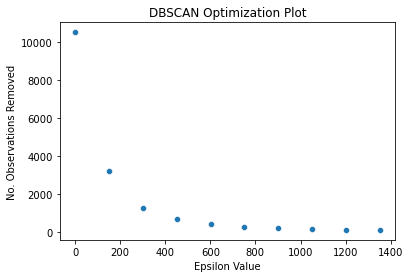

In [9]:
ax = sns.scatterplot(x=eps_lst, y=removed_lst)
ax.set(xlabel="Epsilon Value", ylabel="No. Observations Removed", title="DBSCAN Optimization Plot")
plt.show()

Nuestro experimento muestra que el valor épsilon apropiado para el conjunto de datos es 1501; Utilizando este valor, hemos identificado 98 observaciones dentro de nuestro conjunto de datos. Echemos un vistazo a una muestra aleatoria de las observaciones eliminadas.

In [10]:
houses.loc[removed_indexes].sample(n=30, random_state=20)

,area,rooms,bathroom,parking spaces,floor,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$)
7710,470,4,4,5,19,6900,6741,0,86,13730
8187,700,4,10,0,0,0,15000,8750,226,23980
131,900,4,6,8,0,0,15000,4417,226,19640
8858,800,4,7,8,0,10000,8500,209,128,18840
4563,512,4,6,5,8,7774,3500,2817,45,14140
4966,290,4,4,4,1,4900,1000,1659,13,7572
1072,390,4,4,5,8,8500,8600,3917,109,21130
3060,287,4,4,4,6,7900,11300,2590,144,21930
19,600,4,5,6,0,0,12000,9500,181,21680
5293,850,5,7,8,1,14000,4000,0,51,18050


DBSCAN ha identificado observaciones con errores de entrada de datos. También ha identificado entradas que son muy poco realistas, como las observaciones 1444 o 5293. También ha identificado observaciones en las que no queda inmediatamente claro por qué son valores atípicos, como la observación 9706; sin embargo, dado que DBSCAN funciona según la distancia euclidiana, somos conscientes de que este valor atípico está increíblemente lejos de todos los demás puntos de datos. Desafortunadamente, es imposible saber qué tan lejos está exactamente usando DBSCAN, por lo que lo mejor sería observar observaciones similares y calcular la distancia usted mismo, lo que puede llevar tiempo. Además, probablemente tendrá que calcular la distancia euclidiana para cada una de las observaciones, ya que necesitará comparar qué tan lejos está su valor atípico de los datos no atípicos. Esto puede requerir bastante potencia de procesamiento, especialmente cuando se trabaja con grandes conjuntos de datos.

DBSCAN es un algoritmo de agrupación que, además de clasificar los datos, también puede identificar valores atípicos. También funciona bien con datos multivariados y, como vimos, puede determinar eficazmente anomalías dentro de los datos. Sin embargo, también tiene una serie de desventajas. El método puede resultar bastante difícil de optimizar para un conjunto de datos en particular, como vimos anteriormente. Encontrar valores épsilon y de muestras mínimos adecuados puede requerir mucho tiempo y potencia de procesamiento. Finalmente, como se mencionó anteriormente, la distancia euclidiana, que utiliza el DBSCAN, puede ser bastante problemática, ya que no considera el patrón que siguen los datos, lo que lleva a resultados posiblemente inexactos cuando se trabaja con ciertos conjuntos de datos. Quizás esta sea la razón por la que el valor épsilon óptimo para nuestros datos fue tan alto. Afortunadamente, este problema se puede resolver, ya que la implementación de DBSCAN de sklearn le permite configurar su propio invocable como parámetro, pero esto también requerirá trabajo adicional y optimización para funcionar bien. Por lo tanto, DBSCAN se puede utilizar de manera efectiva, pero requiere mucha preparación para hacerlo

# Red Neuronal

In [11]:
df1 = pd.read_csv("houses_to_rent.csv")
df2 = pd.read_csv("houses_to_rent_v2.csv")

Comprobando muy rápido qué tipo de datos tenemos

In [12]:
df1.head()

,Unnamed: 0,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa,rent amount,property tax,fire insurance,total
0,0,1,240,3,3,4,-,acept,furnished,R$0,"R$8,000","R$1,000",R$121,"R$9,121"
1,1,0,64,2,1,1,10,acept,not furnished,R$540,R$820,R$122,R$11,"R$1,493"
2,2,1,443,5,5,4,3,acept,furnished,"R$4,172","R$7,000","R$1,417",R$89,"R$12,680"
3,3,1,73,2,2,1,12,acept,not furnished,R$700,"R$1,250",R$150,R$16,"R$2,116"
4,4,1,19,1,1,0,-,not acept,not furnished,R$0,"R$1,200",R$41,R$16,"R$1,257"


In [13]:
df2.head()

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$)
0,São Paulo,70,2,1,1,7,acept,furnished,2065,3300,211,42,5618
1,São Paulo,320,4,4,0,20,acept,not furnished,1200,4960,1750,63,7973
2,Porto Alegre,80,1,1,1,6,acept,not furnished,1000,2800,0,41,3841
3,Porto Alegre,51,2,1,0,2,acept,not furnished,270,1112,22,17,1421
4,São Paulo,25,1,1,0,1,not acept,not furnished,0,800,25,11,836


Parece que tenemos dos marcos de datos donde los datos en el primero están separados por ciudad es decir, en df1 y en el segundo marco de datos tenemos el nombre de ciudades específicas, es decir, df2.

hoa = Impuesto de asociación de propietarios

Primero verifiquemos df1 donde los datos se dividen por ciudad o no por ciudad.

1. Primero debemos eliminar ese "R$" que es el símbolo del rand sudafricano.
2. Necesitamos reemplazar las cadenas en las columnas por un número, por ejemplo. aceptar puede ser 1 y no aceptar puede ser 0
3. También hay algunos '-' en nuestra columna de piso, asumiremos que son piso bajo tierra, es decir, piso = 0.
4. Luego hay un "," en la columna total que debemos eliminar para convertirlos a int.

In [14]:
df1_new=df1.replace(regex=[r'\bR\$'],value='')
df1_new = df1_new.replace('acept',1)
df1_new.replace('not acept',0,inplace=True)
df1_new.replace('furnished',1,inplace=True)
df1_new.replace('not furnished',0,inplace=True)
df1_new.replace('-',0,inplace=True)
df1_new.replace(regex=[r'\b,'],value='',inplace=True)

Dividimos el nuevo marco de datos en dos partes, donde ciudad = 1 y ciudad = 0

In [15]:
df1_city = df1_new[df1_new['city']==1]
df1_notcity = df1_new[df1_new['city']==0]

Comprobando que hicimos todo bien

In [16]:
df1_city.head()

,Unnamed: 0,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa,rent amount,property tax,fire insurance,total
0,0,1,240,3,3,4,0,1,1,0,8000,1000,121,9121
2,2,1,443,5,5,4,3,1,1,4172,7000,1417,89,12680
3,3,1,73,2,2,1,12,1,0,700,1250,150,16,2116
4,4,1,19,1,1,0,0,0,0,0,1200,41,16,1257
5,5,1,13,1,1,0,2,1,0,0,2200,42,28,2270


In [17]:
df1_notcity.head()

,Unnamed: 0,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa,rent amount,property tax,fire insurance,total
1,1,0,64,2,1,1,10,1,0,540,820,122,11,1493
10,10,0,60,1,1,0,6,1,0,480,720,20,10,1230
11,11,0,64,1,2,1,4,1,1,406,1550,0,7,1963
15,15,0,56,2,1,1,1,1,0,345,950,11,13,1319
16,16,0,188,2,3,8,0,1,0,0,3010,584,46,3640


No es necesario que las columnas de índice las eliminen

In [18]:
df1_city = df1_city.copy().drop(columns=['Unnamed: 0'])

In [19]:
df1_notcity = df1_notcity.copy().drop(columns=['Unnamed: 0'])

In [20]:
print(df1_city.dtypes)

city               int64
area               int64
rooms              int64
bathroom           int64
parking spaces     int64
floor             object
animal             int64
furniture          int64
hoa               object
rent amount       object
property tax      object
fire insurance    object
total             object
dtype: object


Es por eso que eliminamos "," para poder convertir ese número a int. Si no se elimina, Python lo considera flotante o puede darnos un error en el futuro.

In [21]:
df1_city['total']=df1_city['total'].astype(int)
df1_notcity['total']=df1_notcity['total'].astype(int)

In [22]:
df1_city.head()

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa,rent amount,property tax,fire insurance,total
0,1,240,3,3,4,0,1,1,0,8000,1000,121,9121
2,1,443,5,5,4,3,1,1,4172,7000,1417,89,12680
3,1,73,2,2,1,12,1,0,700,1250,150,16,2116
4,1,19,1,1,0,0,0,0,0,1200,41,16,1257
5,1,13,1,1,0,2,1,0,0,2200,42,28,2270


In [23]:
df1_notcity.head()

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa,rent amount,property tax,fire insurance,total
1,0,64,2,1,1,10,1,0,540,820,122,11,1493
10,0,60,1,1,0,6,1,0,480,720,20,10,1230
11,0,64,1,2,1,4,1,1,406,1550,0,7,1963
15,0,56,2,1,1,1,1,0,345,950,11,13,1319
16,0,188,2,3,8,0,1,0,0,3010,584,46,3640


### Trazaremos un diagrama de dispersión aquí, queremos saber cómo cambia el monto total según el área de nuestra propiedad y también verificaremos que tenga un número diferente de habitaciones que afecte el monto total.
### Trazar es muy simple con plotly, simplemente pase un marco de datos, lo que desea que esté en los ejes x y y también cómo desea usar el color, aquí queremos cambiar nuestro color de acuerdo con la cantidad de habitaciones.
### Plotly se encarga de todo por ti. Tenemos dos parcelas una para la ciudad y otra fuera de la ciudad.

In [24]:
fig = px.scatter(df1_notcity,x='area',y='total',trendline="lowess",color='rooms',title="Not in city")
fig1 = px.scatter(df1_city,x='area',y='total',trendline="lowess",color='rooms',title="In city")

1. Lo que básicamente intentamos hacer a continuación es trazar estos dos gráficos uno al lado del otro. Este es simplemente un método muy vago para hacerlo.
2. Este es el método correcto para trazar subtramas.

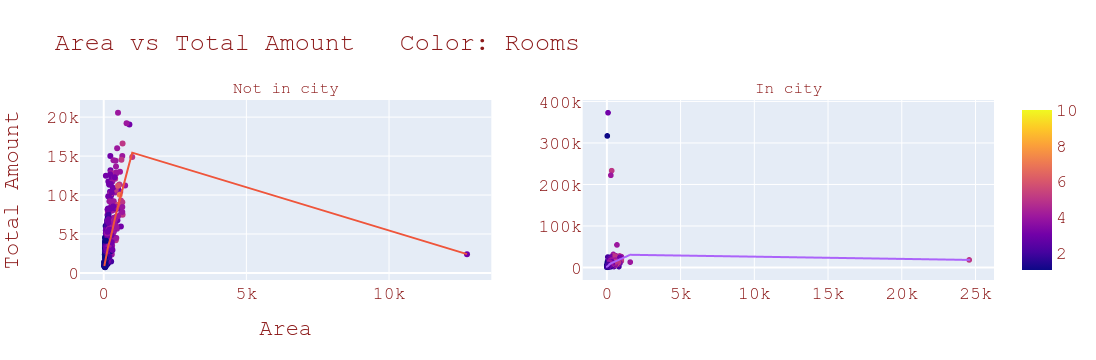

In [25]:
trace1 = fig['data'][0]
trace2 = fig1['data'][0]

fig2 = make_subplots(rows=1, cols=2, shared_xaxes=False,subplot_titles=("Not in city","In city"))
fig2.add_trace(trace1, row=1, col=1)
fig2.add_trace(fig['data'][1], row=1, col=1)
fig2.add_trace(trace2, row=1, col=2)
fig2.add_trace(fig1['data'][1], row=1, col=2)
fig2.update_layout(
    title="Area vs Total Amount \t Color: Rooms",
    xaxis_title="Area",
    yaxis_title="Total Amount",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="#8c1919",
        
        
    ))
iplot(fig2)

1. Puede usar el mouse para acercar el lugar que desea ver (si solo ve una esquina llena de puntos, acerque el mouse)
2. Pase el mouse para ver el valor en ese punto.
3. Aquí vemos algo interesante sobre la trama, nuestra leyenda, es decir, el color depende de nuestro número de habitaciones, cuantas más habitaciones, más brillante se vuelve el color.
4. Podemos ver que en el gráfico de [No es una ciudad] no hay muchos lugares con una gran cantidad de habitaciones... bueno, realmente no hay nada innovador aquí... pero en el gráfico de [ciudad] podemos ver claramente El cambio en el color a medida que aumenta el área aumenta la probabilidad de tener más habitaciones, por lo que los colores se vuelven más brillantes y también aumenta el monto total del alquiler... nuevamente, no es nada que valga el Premio Nobel, pero un gráfico simple aquí puede ayudarnos a entenderlo muy fácilmente.
5. Las casas más caras tienen más habitaciones.

Otra parcela de lado a lado, pero ahora queremos saber si el número de baños en nuestra propiedad significa algo.
Es decir, obviamente la gente va a comprar una casa con baño, pero queremos saber que hacer más baño significa más dinero... solo por diversión.

También revisando el conjunto de datos encontré que en la columna hao, impuesto a la propiedad, algunos de los valores no eran números enteros.
La columna hoa tenía algunos valores = 'Información sem' y el impuesto a la propiedad de la columna tenía algunos valores = 'Incluso'
No usaremos estas columnas porque solo necesitamos analizar el monto total porque al final eso es lo que queremos saber cuánto dinero necesitamos dar.

In [26]:
df1[df1['hoa']=='Sem info'].head(3)

,Unnamed: 0,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa,rent amount,property tax,fire insurance,total
35,35,1,250,4,4,2,-,not acept,not furnished,Sem info,"R$6,600",R$0,R$100,"R$6,700"
38,38,1,180,3,4,5,-,acept,not furnished,Sem info,"R$3,300",R$266,R$50,"R$3,616"
157,157,1,340,4,6,6,-,acept,furnished,Sem info,"R$15,000",R$250,R$226,"R$15,480"


In [27]:
df1[df1['property tax']=='Incluso'].head(3)

,Unnamed: 0,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa,rent amount,property tax,fire insurance,total
409,409,1,30,1,1,1,11,acept,furnished,R$500,"R$2,570",Incluso,R$8,"R$3,078"
991,991,1,65,2,1,1,4,acept,not furnished,R$800,"R$1,750",Incluso,R$7,"R$2,557"
1355,1355,1,45,1,1,1,9,acept,not furnished,R$427,"R$2,142",Incluso,R$20,"R$2,589"


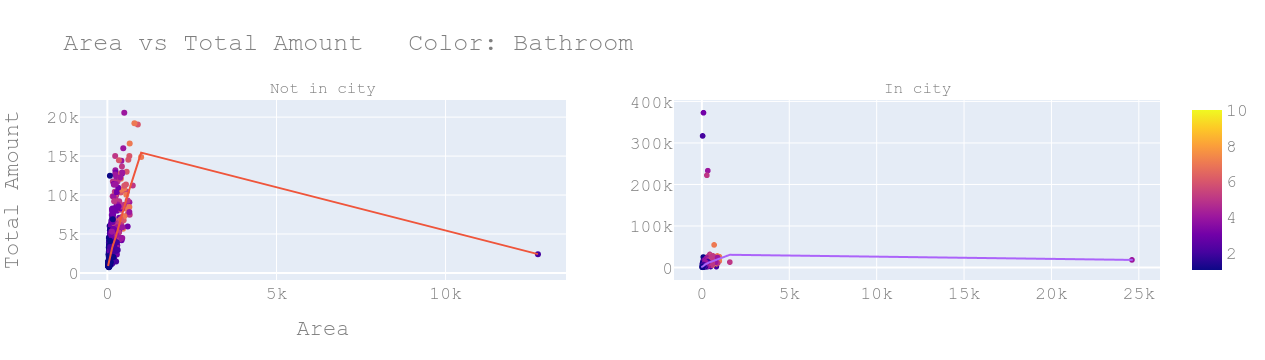

In [28]:
fig0 = px.scatter(df1_notcity,x='area',y='total',trendline="lowess",color='bathroom',title="Not in city")
fig10 = px.scatter(df1_city,x='area',y='total',trendline="lowess",color='bathroom',title="In city")
trace12 = fig0['data'][0]
trace21 = fig10['data'][0]

fig21 = make_subplots(rows=1, cols=2, shared_xaxes=False,subplot_titles=("Not in city","In city"))
fig21.add_trace(trace12, row=1, col=1)
fig21.add_trace(fig0['data'][1], row=1, col=1)
fig21.add_trace(trace21, row=1, col=2)
fig21.add_trace(fig10['data'][1], row=1, col=2)
fig21.update_layout(
    title="Area vs Total Amount \t Color: Bathroom",
    xaxis_title="Area",
    yaxis_title="Total Amount",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="#7f7f7f",
        
        
    ))
iplot(fig21)

Nuevamente vemos algo similar a nuestro gráfico de "habitaciones"... las casas más caras tienen más cantidad de baños

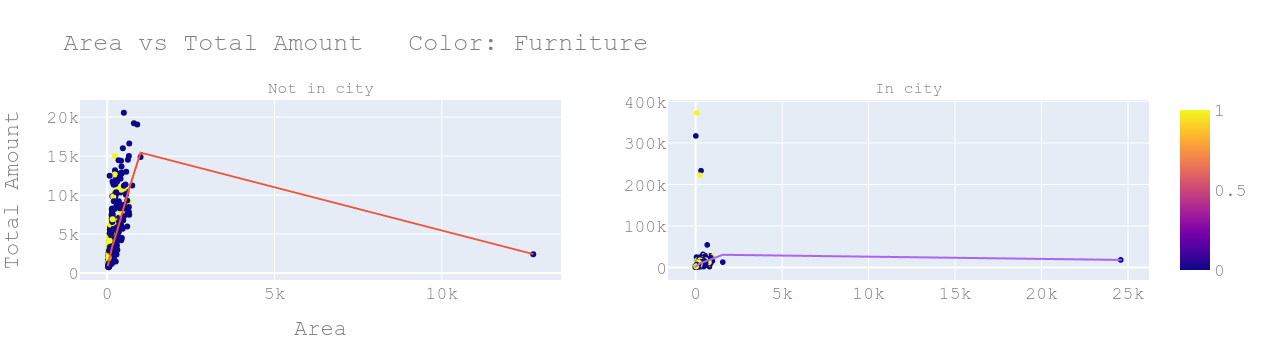

In [29]:
fig01 = px.scatter(df1_notcity,x='area',y='total',trendline="lowess",color='furniture',title="Not in city")
fig101 = px.scatter(df1_city,x='area',y='total',trendline="lowess",color='furniture',title="In city")
trace121 = fig01['data'][0]
trace211 = fig101['data'][0]

fig211 = make_subplots(rows=1, cols=2, shared_xaxes=False,subplot_titles=("Not in city","In city"))
fig211.add_trace(trace121, row=1, col=1)
fig211.add_trace(fig01['data'][1], row=1, col=1)
fig211.add_trace(trace211, row=1, col=2)
fig211.add_trace(fig101['data'][1], row=1, col=2)
fig211.update_layout(
    title="Area vs Total Amount \t Color: Furniture",
    xaxis_title="Area",
    yaxis_title="Total Amount",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="#7f7f7f",
        
        
    ))
iplot(fig211)

### Ahora pasamos a otro marco de datos, el que tiene nombres de ciudades específicos. Aquí intentaremos predecir el precio total de la casa.

Comprobemos cuántas ciudades únicas tenemos.

In [30]:
uc = df2['city'].unique()

In [31]:
print(uc)

['São Paulo' 'Porto Alegre' 'Rio de Janeiro' 'Campinas' 'Belo Horizonte']


Nosotros hacemos los mismos cambios

In [32]:
df2 = df2.replace('acept',1)
df2.replace('not acept',0,inplace=True)
df2.replace('furnished',1,inplace=True)
df2.replace('not furnished',0,inplace=True)
df2.replace('-',0,inplace=True)

In [33]:
df2.head()

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$)
0,São Paulo,70,2,1,1,7,1,1,2065,3300,211,42,5618
1,São Paulo,320,4,4,0,20,1,0,1200,4960,1750,63,7973
2,Porto Alegre,80,1,1,1,6,1,0,1000,2800,0,41,3841
3,Porto Alegre,51,2,1,0,2,1,0,270,1112,22,17,1421
4,São Paulo,25,1,1,0,1,0,0,0,800,25,11,836


Ahora veamos un diagrama pero coloreado según diferentes ciudades.

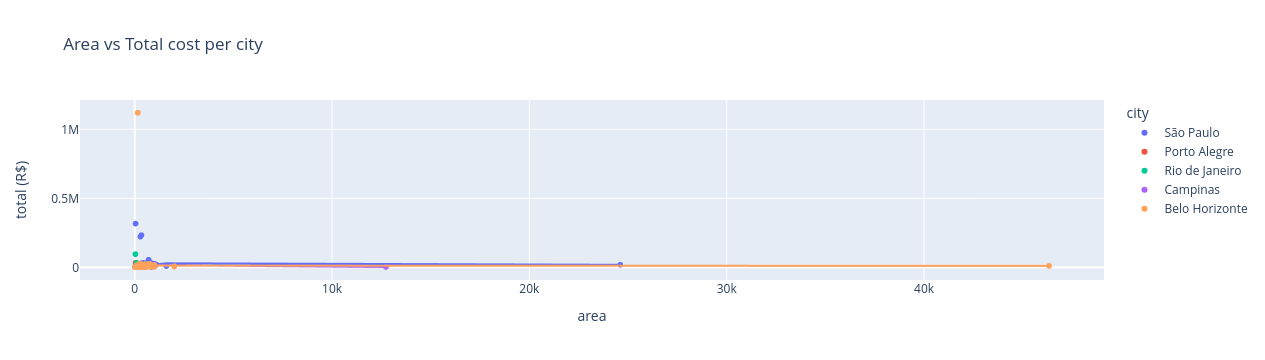

In [34]:
fig3 = px.scatter(df2,x='area',y='total (R$)',trendline="lowess",color='city',title="Area vs Total cost per city")
#fig3.show()
iplot(fig3)

Nuevamente, si ve puntos pequeños que se acercan, también puede hacer clic en la leyenda para habilitar y deshabilitar los puntos de la trama de esa ciudad en particular.

1. Parece que Sao Polo es la ciudad más cara
2. No tenemos muchos datos sobre Porto Alegre
3. También para la misma zona Sao Polo y Río de Janeiro son más caros que Belo Horizonte.

Aquí también vemos que hay algunos valores atípicos, la mayoría de nuestro precio total es inferior a 35 000, excepto unos pocos. Los modelos de regresión lineal a veces son sensibles a los valores atípicos. También parece que tenemos más datos para una sola ciudad: Sao Paulo.

cambiamos el nombre de la ciudad a número y también almacenar el nombre de la ciudad: número en un dict

In [35]:
city_dict = {}
for i in range(0,len(uc)):
    df2.replace(uc[i],i+1,inplace=True)
    city_dict[uc[i]]=i+1
    print("Now city {} is : {}".format(uc[i],i+1))

Now city São Paulo is : 1
Now city Porto Alegre is : 2
Now city Rio de Janeiro is : 3
Now city Campinas is : 4
Now city Belo Horizonte is : 5


En el gráfico anterior parecía que había diferente número de muestras de datos por ciudad.

Lo que estamos haciendo es contar la aparición de cada ciudad en la columna df2['ciudad'], así que usamos value_counts()

print("Total length {}\nNumber of Examples per city \n{}".format(len(df2),df2['city'].value_counts()))

In [36]:
city_dict

{'São Paulo': 1,
 'Porto Alegre': 2,
 'Rio de Janeiro': 3,
 'Campinas': 4,
 'Belo Horizonte': 5}

Entonces, ¿cuál es el problema? Creo que tenemos un conjunto de datos con un número desigual de ejemplos por ciudad... Como vimos antes, el número de ejemplos por ciudad es mayor para Sao Paulo: 5887 de un total de 10692, casi la mitad de ellos.

Bueno, la mayoría de las muestras son de la ciudad de São Paulo, casi la mitad de ellas 5887 y la menor cantidad son de Campinas solo 853.

Comprobemos también el importe total medio que tenemos que gastar en cada ciudad.

In [37]:
mean_total=[]
for i in range(0,len(uc)):
    mean = df2[df2['city']==city_dict[uc[i]]]['total (R$)'].mean()
    mean_total.append(mean)
    print("Mean amount for city {}:{} is {:.2f}".format(i+1,uc[i],mean))

Mean amount for city 1:São Paulo is 6380.83
Mean amount for city 2:Porto Alegre is 2989.78
Mean amount for city 3:Rio de Janeiro is 4611.68
Mean amount for city 4:Campinas is 3173.28
Mean amount for city 5:Belo Horizonte is 6315.24


- Bueno, como se esperaba, São Paulo tiene el promedio más alto = 6380, seguido de cerca por Belo Horizonte con 6315.
- El menos caro es Porto Alegre con casi 2990

In [38]:
xdf = df2[['city','area','rooms','bathroom','floor','furniture']]
xdf.describe()

,city,area,rooms,bathroom,furniture
count,10692.000000,10692.000000,10692.000000,10692.000000,10692.000000
mean,2.102319,149.217920,2.506079,2.236813,0.243734
std,1.434833,537.016942,1.171266,1.407198,0.429354
min,1.000000,11.000000,1.000000,1.000000,0.000000
25%,1.000000,56.000000,2.000000,1.000000,0.000000
50%,1.000000,90.000000,2.000000,2.000000,0.000000
75%,3.000000,182.000000,3.000000,3.000000,0.000000
max,5.000000,46335.000000,13.000000,10.000000,1.000000


Ahora vamos a predecir los precios de estas propiedades.

In [39]:
xdf1= xdf.to_numpy(dtype='float')
y = df2['total (R$)'].to_numpy(dtype='float')

División de prueba de entrenamiento

In [40]:
x_train,x_test,y_train,y_test = train_test_split(xdf1,y,random_state=3,test_size=200)

In [41]:
clf = svm.SVR(kernel='linear')
clf.fit(x_train,y_train)

SVR(kernel='linear')

La precisión de un modelo de regresión no se puede medir como un modelo de clasificación porque es muy poco probable que genere exactamente el mismo número que los datos de etiqueta o los datos verdaderos. En su lugar, usamos algo llamado error r cuadrado, que está entre 0 y 1, donde 0 significa que nuestro modelo no captura ninguna variación en los datos y 1 significa que es perfecto. Aquí hay un buen artículo que lo explica r2. 

https://www.datasciencecentral.com/regression-analysis-how-do-i-interpret-r-squared-and-assess-the/

In [42]:
clf.score(x_test,y_test)

0.5886762708719387

Nuestra precisión es 0,58, lo cual está bien. Además, dado que tenemos más datos sobre una ciudad en particular, nuevamente está bien.

Porque número de ciudad de Sao Paulo = 1

### Pero ahora intentemos construir una red neuronal a partir de pytorch.

In [43]:
xtrain =torch.from_numpy(x_train)
ytrain = torch.from_numpy(y_train)
xtest =torch.from_numpy(x_test)
ytest = torch.from_numpy(y_test)

In [44]:
dataset = TensorDataset(xtrain,ytrain)
dataset_test = TensorDataset(xtest,ytest)
loader = DataLoader(dataset,batch_size = 5)
test_loader = DataLoader(dataset_test,batch_size=5)

Hasta ahora todo era bastante estándar: importamos bibliotecas y luego creamos un conjunto de datos tensoriales. Ahora vamos a crear un modelo.

1. En pytorch necesitas definir tu modelo en una clase

- Nuestro número de entradas es 5, por lo que la primera capa self.layer1 tomará un vector de (5,1) como entrada y generará un vector de (25,1).
- Luego definimos la capa oculta de manera similar con la ayuda de "Linear (entrada, salida)", que es solo una capa de neuronas.
- Capa de salida final de solo tamaño = 1

2. La función de avance es imprescindible... define cómo se producirá el paso de avance.

In [45]:
class NN(nn.Module):
    def __init__(self):
        super(NN,self).__init__()
        self.layer1 = nn.Linear(6,25)
        nn.ReLU()
        self.layer2 = nn.Linear(25,25)
        nn.ReLU()
        self.layer3 = nn.Linear(25,25)
        nn.ReLU()
        self.layer4 = nn.Linear(25,1)
    def forward(self,n):
        out = self.layer1(n)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        
        return out

- Importamos una función de pérdida L1Loss() que es muy robusta contra valores atípicos en el conjunto de datos.
- Un optimizador Adam

In [46]:
#learning_rate = 0.01
model = NN()
model = model.double()
model=model.cuda()
criterion = nn.L1Loss()
criterion.cuda()
optimizer = Adam(model.parameters(),lr=0.1)

In [47]:
total_steps = len(loader)
loss_list = []
num_epochs=5
total_train=0

Importando la puntuación r2 porque así es como los medimos en los modelos de regresión

Este es nuestro circuito de entrenamiento:

Parece complicado pero es muy simple.

1. Tomamos valores de nuestro cargador tensorial, es decir, datos y la etiqueta o valor verdadero.
2. Lo pasamos a través de nuestro modelo (el bucle para agregar en la lista o_list[] se debe a que nuestro tamaño de lote es 5, por lo que el modelo devuelve una salida de tamaño cinco, son cinco entradas diferentes, las agregamos en una lista de salida predicha, también adjuntar las etiquetas)
3. Ahora que nuestro modelo tiene la salida, necesitamos calcular la pérdida para pasarla a nuestro criterio de pérdida.
4. Se calcula la pérdida... necesitamos propagarla hacia atrás, es decir, retropropagación.
5. Ahora calcule los gradientes en función de esas pérdidas y el optimizador dará un paso... con suerte en la dirección correcta hacia los mínimos globales.
6. Imprima la salida de cada época.

In [58]:
intrinsic_normal = torch.tensor(o_list).cuda().data.cpu().numpy()
intrinsic_normal = torch.tensor(ll).cuda().data.cpu().numpy()

In [64]:
model.train()

for epoch in range(0,num_epochs):
    o_list = []
    ll = []
    for i,(data,label) in enumerate(loader):
        outp = model(data.cuda()) #1
        [o_list.append(o.cpu().item()) for o in outp]
        [ll.append(l.item()) for l in label]
        loss = criterion(outp,label.reshape(-1,1).cuda()) #2
        loss_list.append(loss)
        optimizer.zero_grad()#3
        loss.backward()#4
        optimizer.step()#5
        total_train+=1
    print("-------------------* Output {} *------------------------".format(epoch+1)) #6
    print("Total steps {}/{}\nLoss {}\nR2 score {}".format(i,total_steps,loss.item(), r2_score(o_list,ll)))  
    #print("Total steps {}/{}\nLoss {}\nR2 score ".format(i,total_steps,loss.item()))  

-------------------* Output 1 *------------------------
Total steps 2098/2099
Loss 3317.8153789027765
R2 score -2.7350955840148705
-------------------* Output 2 *------------------------
Total steps 2098/2099
Loss 3358.1325896599346
R2 score -2.865583930670208
-------------------* Output 3 *------------------------
Total steps 2098/2099
Loss 2607.29453340088
R2 score -2.590934302137319
-------------------* Output 4 *------------------------
Total steps 2098/2099
Loss 3334.769887941143
R2 score -1.4233320137458176
-------------------* Output 5 *------------------------
Total steps 2098/2099
Loss 2885.125024304323
R2 score -2.335297636840617


Probemos nuestra NN en nuevos datos no vistos

In [65]:
o_list=[]
ll=[]
model.eval()
for i,(data,label) in enumerate(test_loader):
    outp = model(data.cuda())
    [o_list.append(o.cpu().item()) for o in outp]
    [ll.append(l.item()) for l in label]
    total_train+=1
    print("-------------------* Output *------------------------")
    print("Total steps {}/{}\nR2 score {}".format(i,len(test_loader),r2_score(o_list,ll)))

-------------------* Output *------------------------
Total steps 0/40
R2 score 0.6893791409943479
-------------------* Output *------------------------
Total steps 1/40
R2 score 0.7160823598578199
-------------------* Output *------------------------
Total steps 2/40
R2 score 0.6524238936662363
-------------------* Output *------------------------
Total steps 3/40
R2 score 0.5464282998011896
-------------------* Output *------------------------
Total steps 4/40
R2 score 0.44626124904693754
-------------------* Output *------------------------
Total steps 5/40
R2 score 0.32070943756503145
-------------------* Output *------------------------
Total steps 6/40
R2 score 0.2551678297692588
-------------------* Output *------------------------
Total steps 7/40
R2 score 0.2974775868935148
-------------------* Output *------------------------
Total steps 8/40
R2 score -0.04639551815007881
-------------------* Output *------------------------
Total steps 9/40
R2 score 0.11097248602191923
-----

Bueno, la precisión es definitivamente mucho peor que la SVR... pero ajustando los hiperparámetros se puede lograr una mayor precisión.

In [66]:
svm_pred = []
for i in x_test:
    pred = clf.predict(i.reshape(1,-1))
    svm_pred.append(pred.item())

Comparemos nuestras salidas por SVR y red neuronal con el valor verdadero 

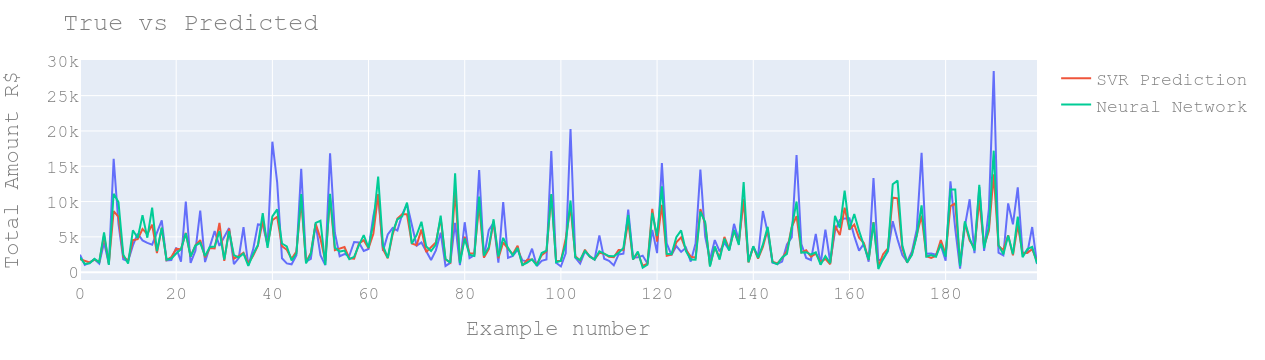

In [67]:
fig4 = px.line(x=range(0,200),y=ll)
fig4.add_scatter(y=svm_pred,name="SVR Prediction")
fig4.add_scatter(y=o_list,name="Neural Network")
fig4.update_layout(
    title="True vs Predicted",
    xaxis_title="Example number",
    yaxis_title="Total Amount R$",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="#7f7f7f",))
        
iplot(fig4)

### La línea azul es el precio real.

Parece que nuestra red neuronal es buena para predecir valores altos pero no tan buena para los más bajos. SVR realmente hace un trabajo decente al dar un valor de salida... no es perfecto y no debería serlo porque solo queremos dar una estimación, los negocios de propiedades en la vida real están influenciados por muchos factores que van desde las habilidades del agente de bienes raíces hasta la fe. de personas en su horóscopo.

Podemos imprimir cada valor y también comprobar manualmente la diferencia.

In [68]:
for i in range(0,len(ll)):
    print("Output of neural network: {:.2f} , Output of SVR: {:.2f} ,  True: {}".format(svm_pred[i],o_list[i],ll[i]))

Output of neural network: 1846.56 , Output of SVR: 2102.21 ,  True: 2477.0
Output of neural network: 1604.14 , Output of SVR: 1174.59 ,  True: 1037.0
Output of neural network: 1390.21 , Output of SVR: 1266.90 ,  True: 1350.0
Output of neural network: 1782.84 , Output of SVR: 1879.89 ,  True: 1816.0
Output of neural network: 1471.56 , Output of SVR: 1400.74 ,  True: 1218.0
Output of neural network: 5203.31 , Output of SVR: 5640.58 ,  True: 4183.0
Output of neural network: 1241.07 , Output of SVR: 1021.53 ,  True: 1150.0
Output of neural network: 8651.64 , Output of SVR: 11100.22 ,  True: 16040.0
Output of neural network: 7814.08 , Output of SVR: 9917.31 ,  True: 6834.0
Output of neural network: 2218.66 , Output of SVR: 2476.83 ,  True: 1820.0
Output of neural network: 1608.59 , Output of SVR: 1223.92 ,  True: 1542.0
Output of neural network: 4533.75 , Output of SVR: 5931.28 ,  True: 3781.0
Output of neural network: 4669.83 , Output of SVR: 4846.45 ,  True: 5445.0
Output of neural networ